# 0.Importing Packages and the data

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import the dataset
telecom = pd.read_csv("telecom_churn_data.csv")
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [ ]:
# rough study of data
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


# 1.Filter High Value Customers

## Define total_rech_data_amt_X 
total_rech_data_amt_X = av_rech_amt_data_X * total_rech_data_X
Where X is the month (6,7,8,9)

In [ ]:
telecom['total_rech_data_amt_6'] = telecom['av_rech_amt_data_6'] * telecom['total_rech_data_6']
telecom['total_rech_data_amt_7'] = telecom['av_rech_amt_data_7'] * telecom['total_rech_data_7']
telecom['total_rech_data_amt_8'] = telecom['av_rech_amt_data_8'] * telecom['total_rech_data_8']
telecom['total_rech_data_amt_9'] = telecom['av_rech_amt_data_9'] * telecom['total_rech_data_9']

Drop the columns total_rech_data_X and av_rech_amt_data_X

In [ ]:
# Drop the columns
telecom.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'],axis = 1,inplace = True)

## 70th Percentile of average recharge amount in first 2 months

In [ ]:
telecom_av_rech_6_7 = (telecom['total_rech_amt_6'].fillna(0) 
+ telecom['total_rech_amt_7'].fillna(0) 
+ telecom['total_rech_data_amt_6'].fillna(0) 
+ telecom['total_rech_data_amt_7'].fillna(0))/2

In [ ]:
telecom_av_rech_6_7

0         559.0
1         306.0
2         241.5
3         270.0
4         301.0
          ...  
99994      85.0
99995     110.0
99996      98.5
99997    1602.0
99998     432.0
Length: 99999, dtype: float64

In [ ]:
# 70th percentile value
percentile_70_6_7 = np.percentile(telecom_av_rech_6_7, 70.0)
print("70th percentile - ", percentile_70_6_7)

70th percentile -  478.0


In [ ]:
# fitler the given data set based on 70th percentile
telecom_hv_cust = telecom[telecom_av_rech_6_7 >= percentile_70_6_7]

In [ ]:
telecom_hv_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 222 entries, mobile_number to total_rech_data_amt_9
dtypes: float64(175), int64(35), object(12)
memory usage: 51.0+ MB


# 2.Defining Target varibale - churn

In [ ]:
# Define 'churn' as given in the problem statement
telecom_hv_cust['churn'] = np.where(telecom_hv_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 1,0)
telecom_hv_cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,total_rech_data_amt_9,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,NaN,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,802,57.74,19.38,18.74,0.00,NaN,NaN,NaN,NaN,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,315,21.03,910.65,122.16,0.00,NaN,354.0,207.0,NaN,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,720,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,604,40.45,51.86,0.00,0.00,NaN,712.0,540.0,252.0,0


## Imbalance ratio in churn

In [ ]:
# lets find out imbalance in churn
telecom_hv_cust['churn'].value_counts()/len(telecom_hv_cust)*100

0    91.863605
1     8.136395
Name: churn, dtype: float64

**OBSERVATIONS**
* There is very high imbalance in the data.
* Imbalance ration is approx 92:8
* We will do imbalance treatment later

# 3.Data Preparation

## Drop columns with only one unique values

In [ ]:
for col in telecom_hv_cust.columns:
    if telecom_hv_cust[col].nunique() == 1:
        telecom_hv_cust.drop(col,axis=1,inplace = True)

telecom_hv_cust.head()

,mobile_number,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,total_rech_data_amt_9,churn
0,7000842753,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,NaN,1
7,7000701601,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,NaN,453.43,...,802,57.74,19.38,18.74,0.00,NaN,NaN,NaN,NaN,1
8,7001524846,378.721,492.223,137.362,166.787,413.69,351.03,35.08,33.46,94.66,...,315,21.03,910.65,122.16,0.00,NaN,354.0,207.0,NaN,0
21,7002124215,514.453,597.753,637.760,578.596,102.41,132.11,85.14,161.63,757.93,...,720,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
23,7000887461,74.350,193.897,366.966,811.480,48.96,50.66,33.58,15.74,85.41,...,604,40.45,51.86,0.00,0.00,NaN,712.0,540.0,252.0,0


## Check null values

In [ ]:
# Check the null values
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

arpu_3g_9                   49.268358
fb_user_9                   49.268358
date_of_last_rech_data_9    49.268358
max_rech_data_9             49.268358
count_rech_2g_9             49.268358
                              ...    
max_rech_amt_8               0.000000
max_rech_amt_7               0.000000
max_rech_amt_6               0.000000
total_rech_amt_9             0.000000
churn                        0.000000
Length: 207, dtype: float64

In [ ]:
# Drop Columns with > 30% of missing values except 9th Month's columns
cols = telecom_hv_cust.columns
telecom_null_perc = telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)
telecom_null_df = pd.DataFrame({'col_name': cols, 'perc_null': telecom_null_perc})

drop_cols = telecom_null_df.loc[(telecom_null_df["col_name"].str.contains('_9')==False) & (telecom_null_df["perc_null"] > 30.0)]["col_name"]

In [ ]:
# Drop these columns
telecom_hv_cust.drop(drop_cols, axis=1,inplace = True)
telecom_hv_cust.shape

(30001, 180)

## Check columns with object datatype

In [ ]:
# Capture the object columns
obj_cols = [col for col in telecom_hv_cust.columns if telecom_hv_cust[col].dtype=='O']
obj_cols

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_9']

In [ ]:
telecom_hv_cust[obj_cols].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_9
0,6/21/2014,7/16/2014,8/8/2014,9/28/2014,NaN
7,6/27/2014,7/25/2014,8/26/2014,9/30/2014,NaN
8,6/25/2014,7/31/2014,8/30/2014,9/30/2014,NaN
21,6/30/2014,7/31/2014,8/31/2014,9/30/2014,NaN
23,6/18/2014,7/7/2014,8/24/2014,9/28/2014,9/9/2014


**OBSERVATIONS**
* These above columns can be converted to datatime

In [ ]:
# convert to datetime
for col in obj_cols:
    telecom_hv_cust[col] = pd.to_datetime(telecom_hv_cust[col])

telecom_hv_cust.shape

(30001, 180)

## Drop highly correlated columns

In [ ]:
# lets check the correlation amongst the features, drop the highly correlated ones
cor = telecom_hv_cust.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

monthly_3g_6      vol_3g_mb_6         0.601308
total_ic_mou_7    loc_ic_t2t_mou_7    0.601684
arpu_2g_9         count_rech_3g_9     0.602386
total_og_mou_8    onnet_mou_9         0.603450
total_rech_amt_8  arpu_6              0.603673
                                        ...   
isd_og_mou_8      isd_og_mou_7        0.949809
                  isd_og_mou_6        0.950194
total_rech_amt_9  arpu_9              0.950539
total_rech_amt_8  arpu_8              0.955351
sachet_2g_9       count_rech_2g_9     0.980131
Length: 337, dtype: float64

In [ ]:
# Drop the columns with high correlation (+/- 60%)
drop_col_list = ['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
                'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','arpu_2g_9','count_rech_2g_9','count_rech_3g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
                 
telecom_hv_cust.drop(drop_col_list, axis=1, inplace=True)
telecom_hv_cust.shape

(30001, 125)

In [ ]:
cor = telecom_hv_cust.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

roam_og_mou_8   roam_og_mou_7    0.604862
offnet_mou_8    offnet_mou_6     0.604877
std_og_mou_9    offnet_mou_9     0.608690
roam_ic_mou_8   roam_ic_mou_7    0.611479
monthly_3g_7    monthly_3g_6     0.611599
                                   ...   
isd_og_mou_9    isd_og_mou_8     0.893526
total_ic_mou_9  loc_ic_mou_9     0.899697
isd_og_mou_7    isd_og_mou_6     0.933275
isd_og_mou_8    isd_og_mou_7     0.949809
                isd_og_mou_6     0.950194
Length: 111, dtype: float64

## Delete columns of 9th month

In [ ]:
# Now we will delete 9th month columns because we would predict churn/non-churn later based on data from the 1st 3 months
cols_to_drop = [col for col in telecom_hv_cust.columns if '_9' in col]
print(cols_to_drop)

telecom_hv_cust.drop(cols_to_drop, axis=1, inplace=True)

telecom_hv_cust.shape

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'total_rech_data_amt_9']


(30001, 88)

In [ ]:
# Check the dataset again
null_vals = (telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)
null_vals

loc_og_t2c_mou_8      3.913203
roam_ic_mou_8         3.913203
spl_og_mou_8          3.913203
isd_og_mou_8          3.913203
std_og_mou_8          3.913203
                        ...   
last_day_rch_amt_7    0.000000
last_day_rch_amt_8    0.000000
vol_2g_mb_6           0.000000
vol_2g_mb_7           0.000000
churn                 0.000000
Length: 88, dtype: float64

In [ ]:
drop_cols = null_vals[null_vals>0]
drop_cols.index

Index(['loc_og_t2c_mou_8', 'roam_ic_mou_8', 'spl_og_mou_8', 'isd_og_mou_8',
       'std_og_mou_8', 'std_ic_mou_8', 'std_og_t2f_mou_8', 'loc_og_mou_8',
       'std_ic_t2t_mou_8', 'og_others_8', 'spl_ic_mou_8', 'roam_og_mou_8',
       'std_ic_t2f_mou_8', 'onnet_mou_8', 'ic_others_8', 'offnet_mou_8',
       'isd_ic_mou_8', 'loc_ic_mou_8', 'ic_others_6', 'og_others_6',
       'std_ic_mou_6', 'spl_og_mou_6', 'loc_ic_mou_6', 'isd_og_mou_6',
       'onnet_mou_6', 'roam_og_mou_6', 'std_og_mou_6', 'isd_ic_mou_6',
       'spl_ic_mou_6', 'std_og_t2f_mou_6', 'offnet_mou_6', 'loc_og_mou_6',
       'roam_ic_mou_6', 'loc_og_t2c_mou_6', 'std_ic_t2f_mou_6',
       'std_ic_t2t_mou_6', 'std_ic_t2f_mou_7', 'std_ic_mou_7', 'isd_ic_mou_7',
       'ic_others_7', 'spl_ic_mou_7', 'og_others_7', 'std_ic_t2t_mou_7',
       'loc_og_mou_7', 'loc_ic_mou_7', 'onnet_mou_7', 'offnet_mou_7',
       'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2c_mou_7',
       'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_og_m

**OBSERVATIONS**
* There are few columns with ~4% null values

In [ ]:
# Drop these rows
for col in drop_cols.index:
  telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust[col])]

In [ ]:
# lets check the dataset again
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

mobile_number         0.0
arpu_6                0.0
last_day_rch_amt_6    0.0
max_rech_amt_8        0.0
max_rech_amt_7        0.0
                     ... 
std_og_mou_8          0.0
std_og_mou_7          0.0
std_og_mou_6          0.0
std_og_t2f_mou_8      0.0
churn                 0.0
Length: 88, dtype: float64

# 4.Data Visualization

In [ ]:
# fucntion to plot histograms
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    # For displaying purposes, pick columns that have between 1 and 50 unique values
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] 
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
# function to plot correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = "Telecom Churn"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [ ]:
# function to plot scatter plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


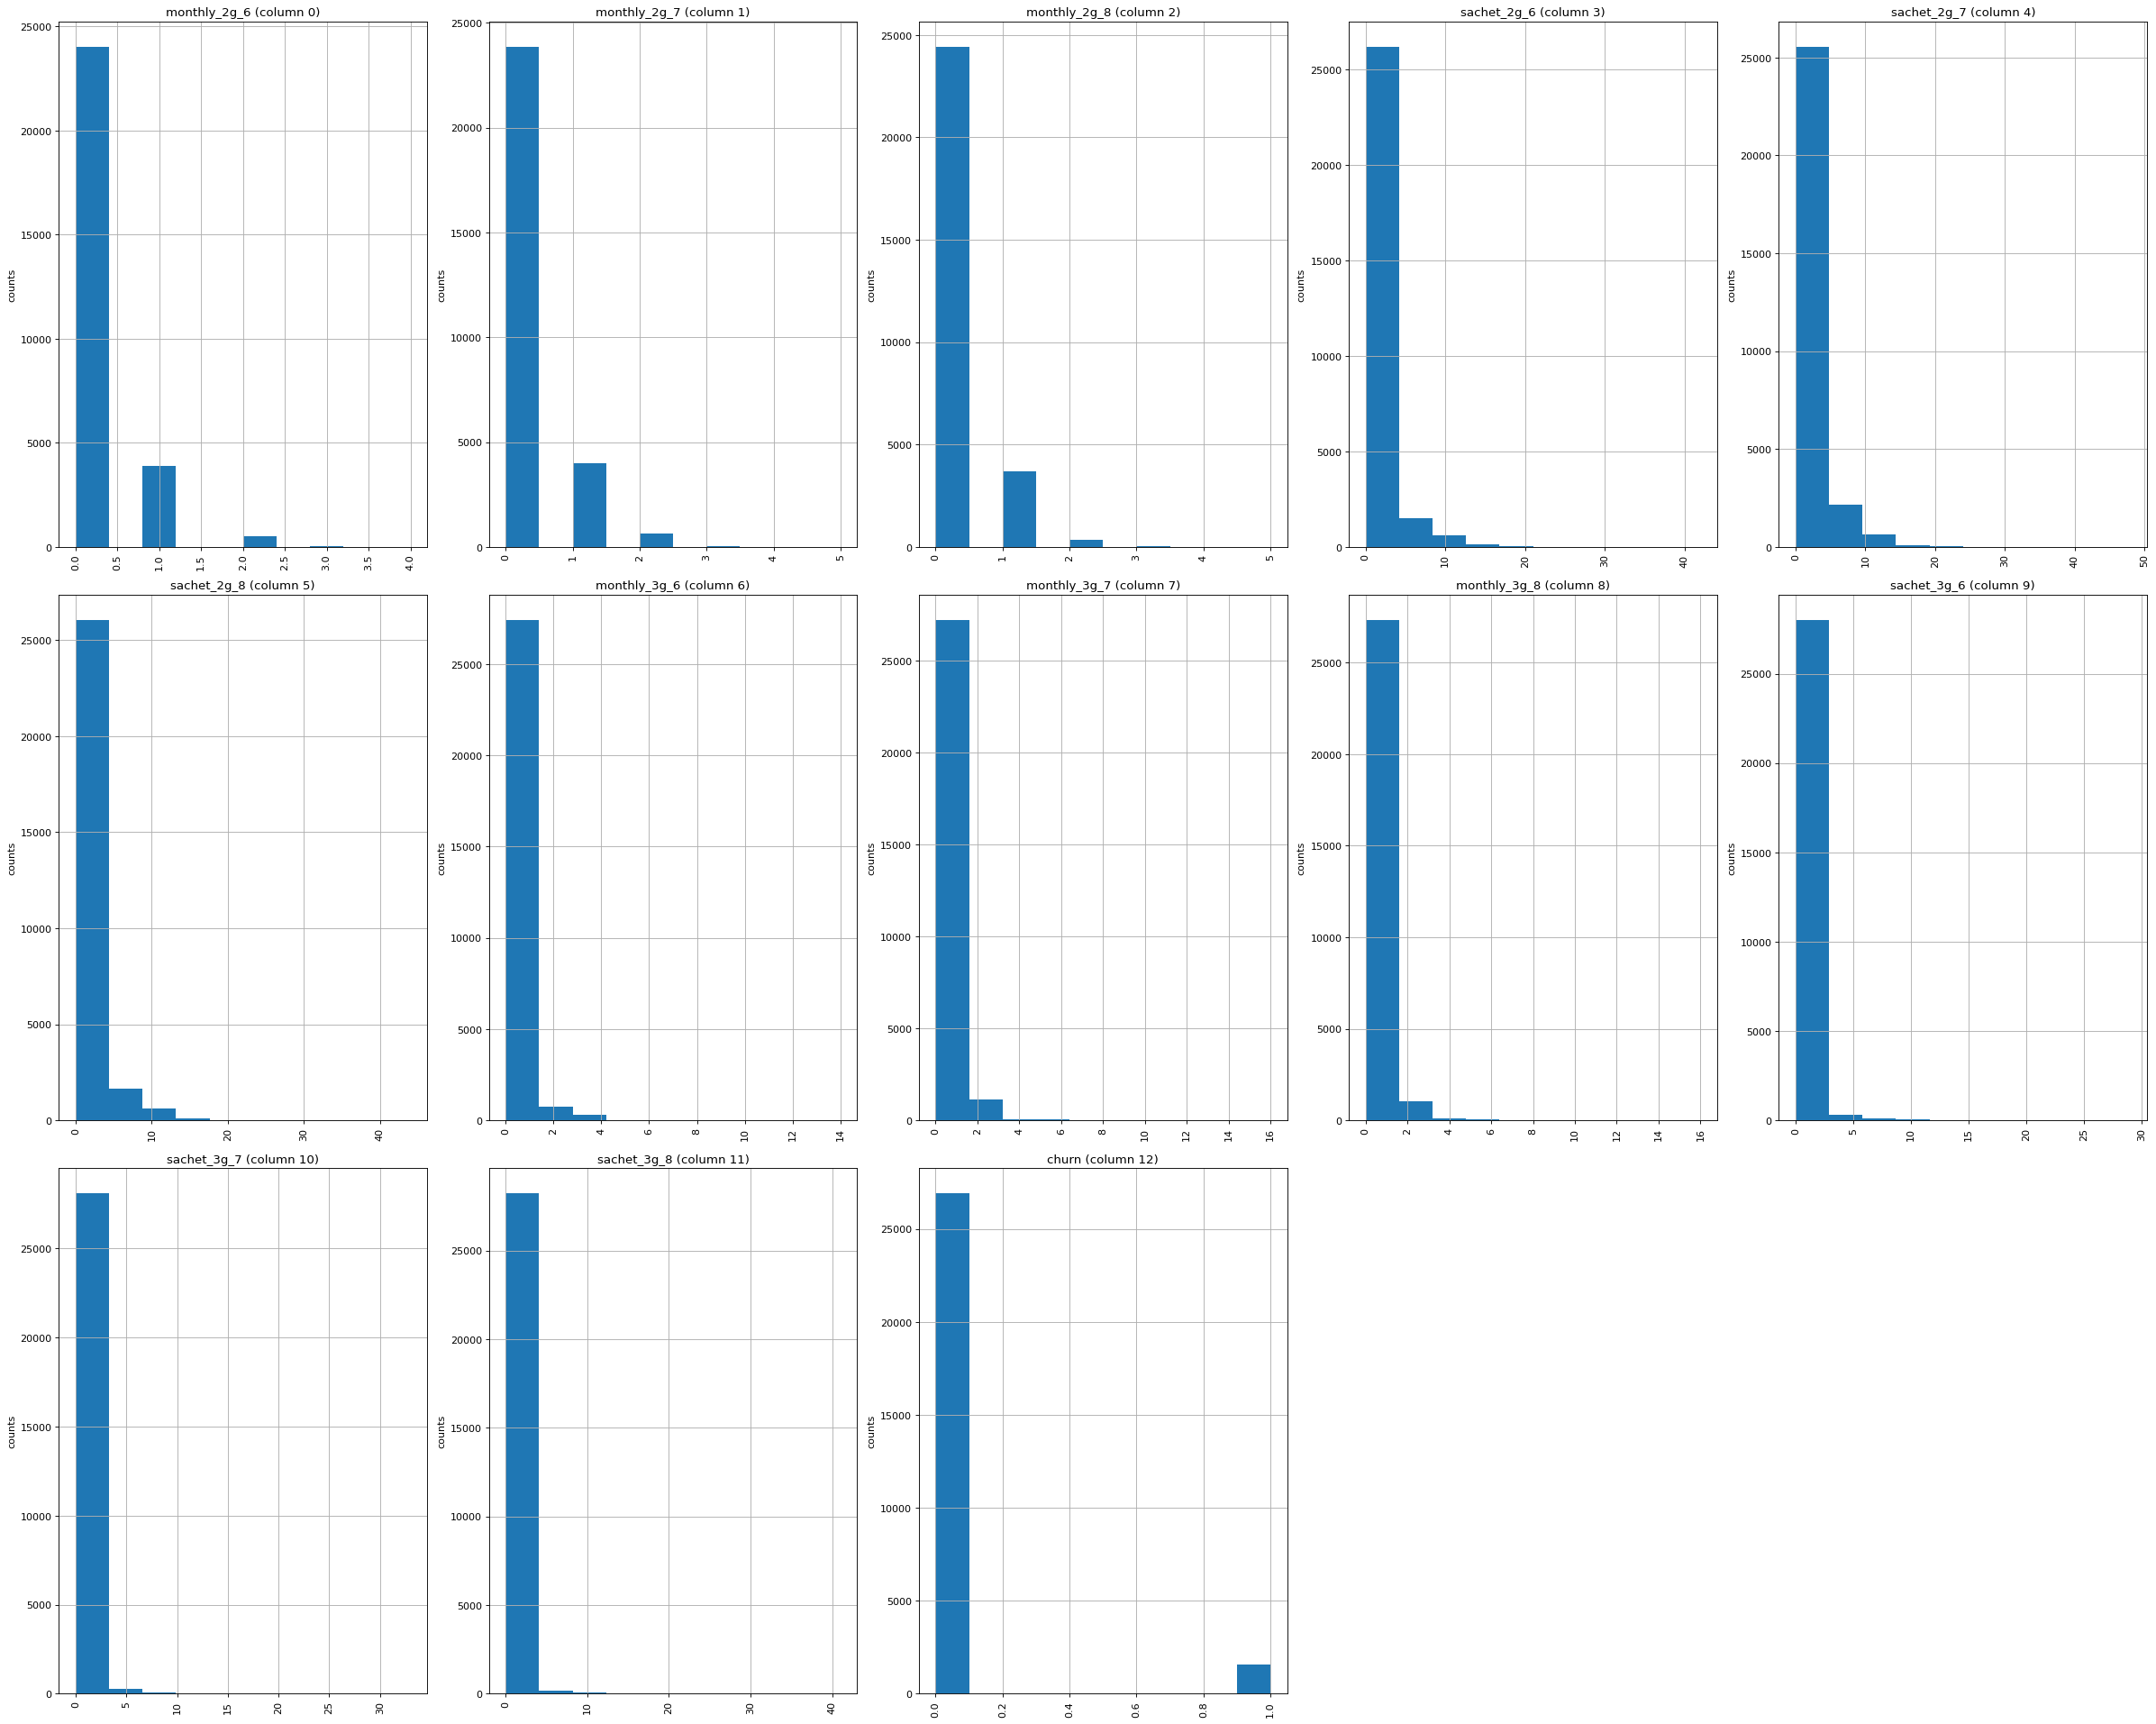

In [ ]:
# call the function to plot the graphs
plotPerColumnDistribution(telecom_hv_cust, telecom_hv_cust.shape[1], 5)

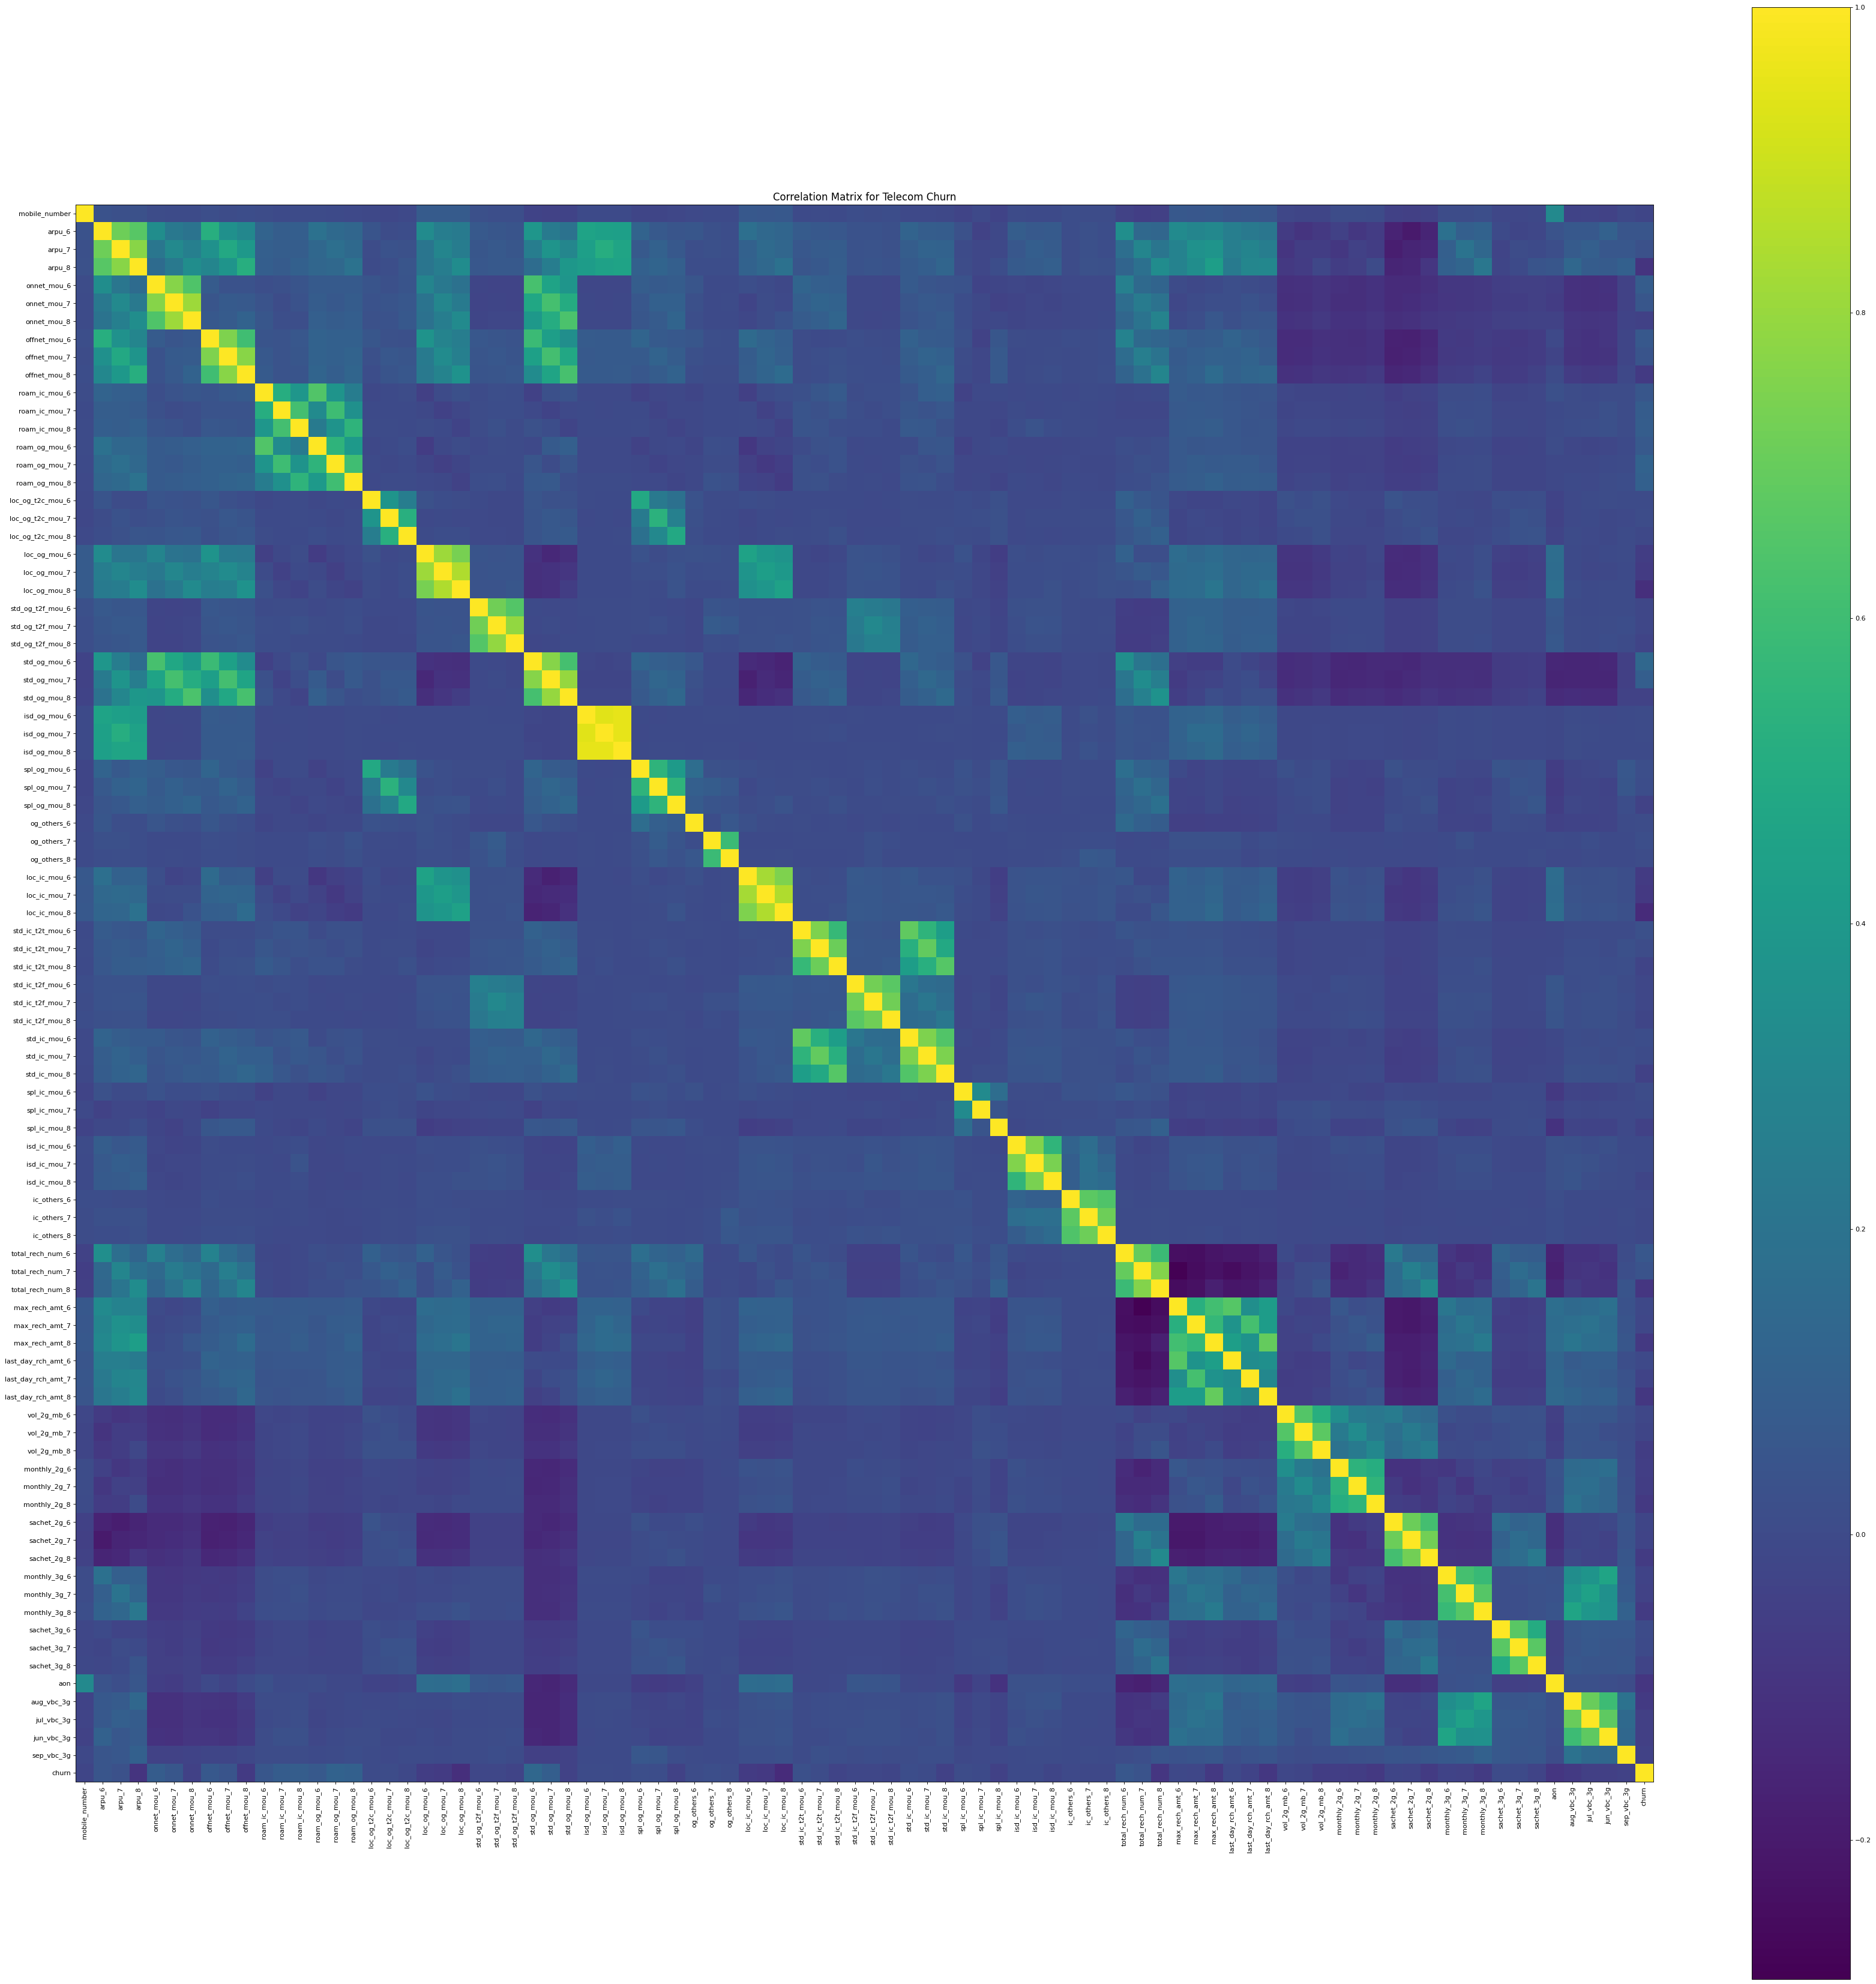

In [ ]:
plotCorrelationMatrix(telecom_hv_cust, 53)

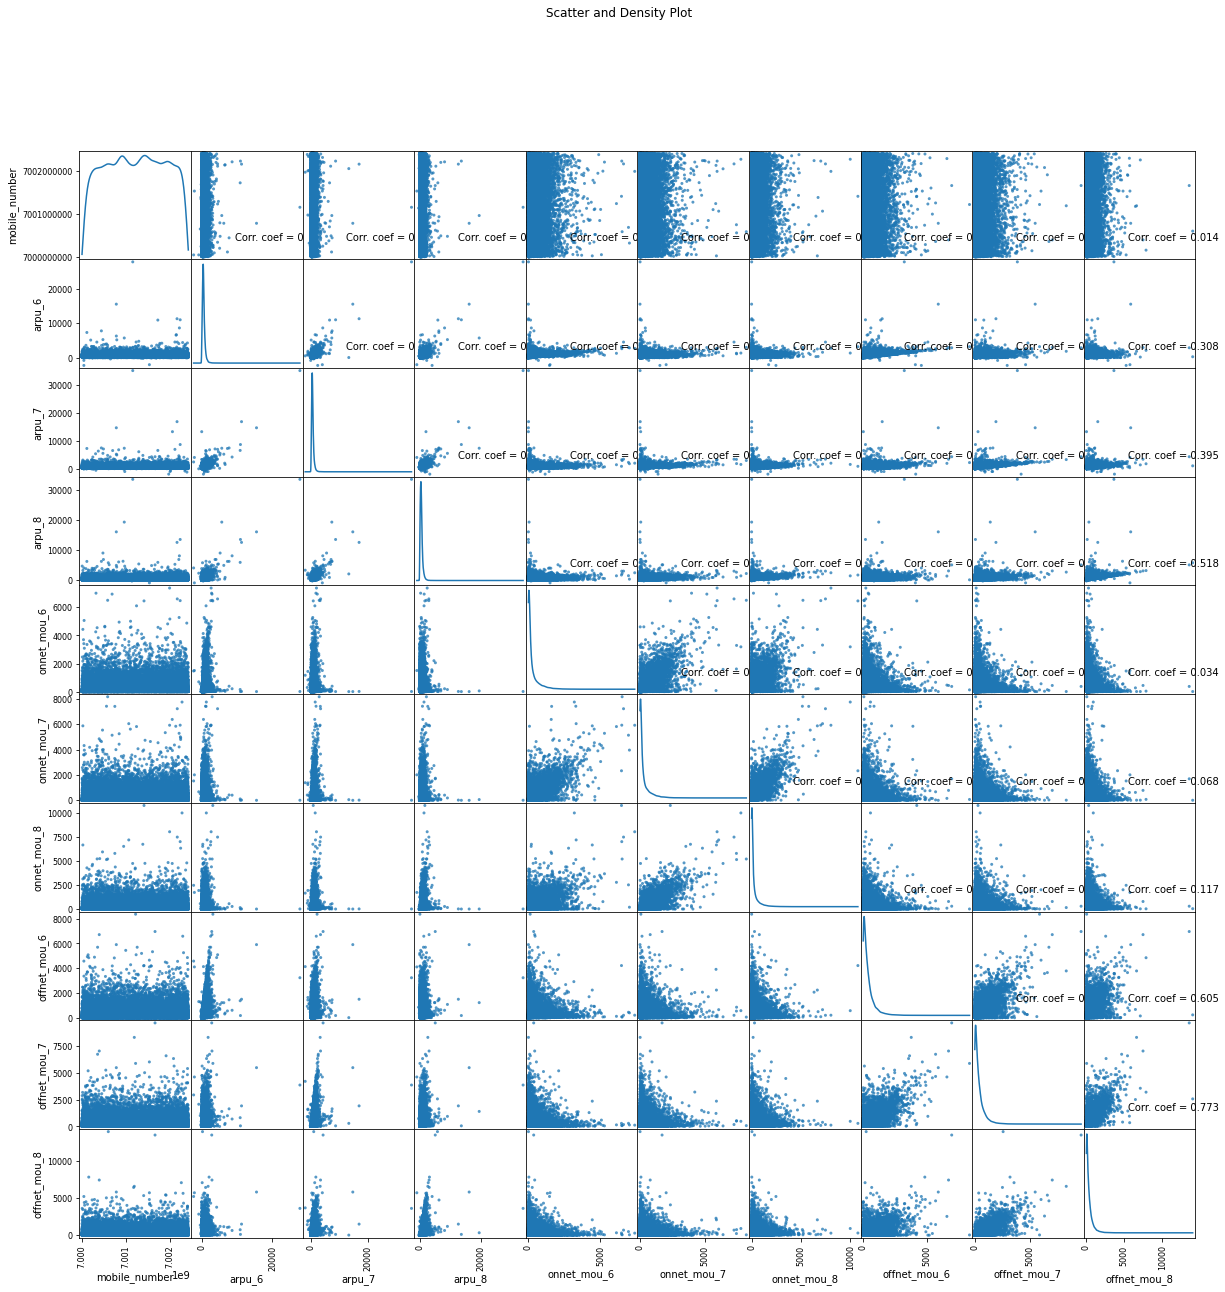

In [ ]:
plotScatterMatrix(telecom_hv_cust, 20, 10)

# 5.Derive new feautres from the existing columns

## Create columns that are average of 6th and 7th months

In [ ]:
# Create list of columns belonging to 6th and 7th months
col_list = telecom_hv_cust.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (telecom_hv_cust.shape)

(28504, 88)


In [ ]:
# Calculate the average
for col in col_list.unique():
    avg_col_name = "avg_"+col+"_av67" # Name of the new columns
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_hv_cust[avg_col_name] = (telecom_hv_cust[col_6]  + telecom_hv_cust[col_7])/ 2

In [ ]:
# Shape before dropping columns
telecom_hv_cust.shape

(28504, 115)

In [ ]:
# Drop the original columns whose average was calculated
col_to_drop = telecom_hv_cust.filter(regex='_6|_7').columns
telecom_hv_cust.drop(col_to_drop, axis=1, inplace=True)

# Shape after dropping columns
telecom_hv_cust.shape

(28504, 61)

## Convert AON (Age on Network) to months

In [ ]:
# lets now convert AON (Age on Network) in months
telecom_hv_cust['aon_mon'] = telecom_hv_cust['aon']/30
telecom_hv_cust.drop('aon', axis=1, inplace=True)
telecom_hv_cust['aon_mon'].head()

7     26.733333
8     10.500000
21    24.000000
23    20.133333
33    44.266667
Name: aon_mon, dtype: float64

# 6.Visualize data again

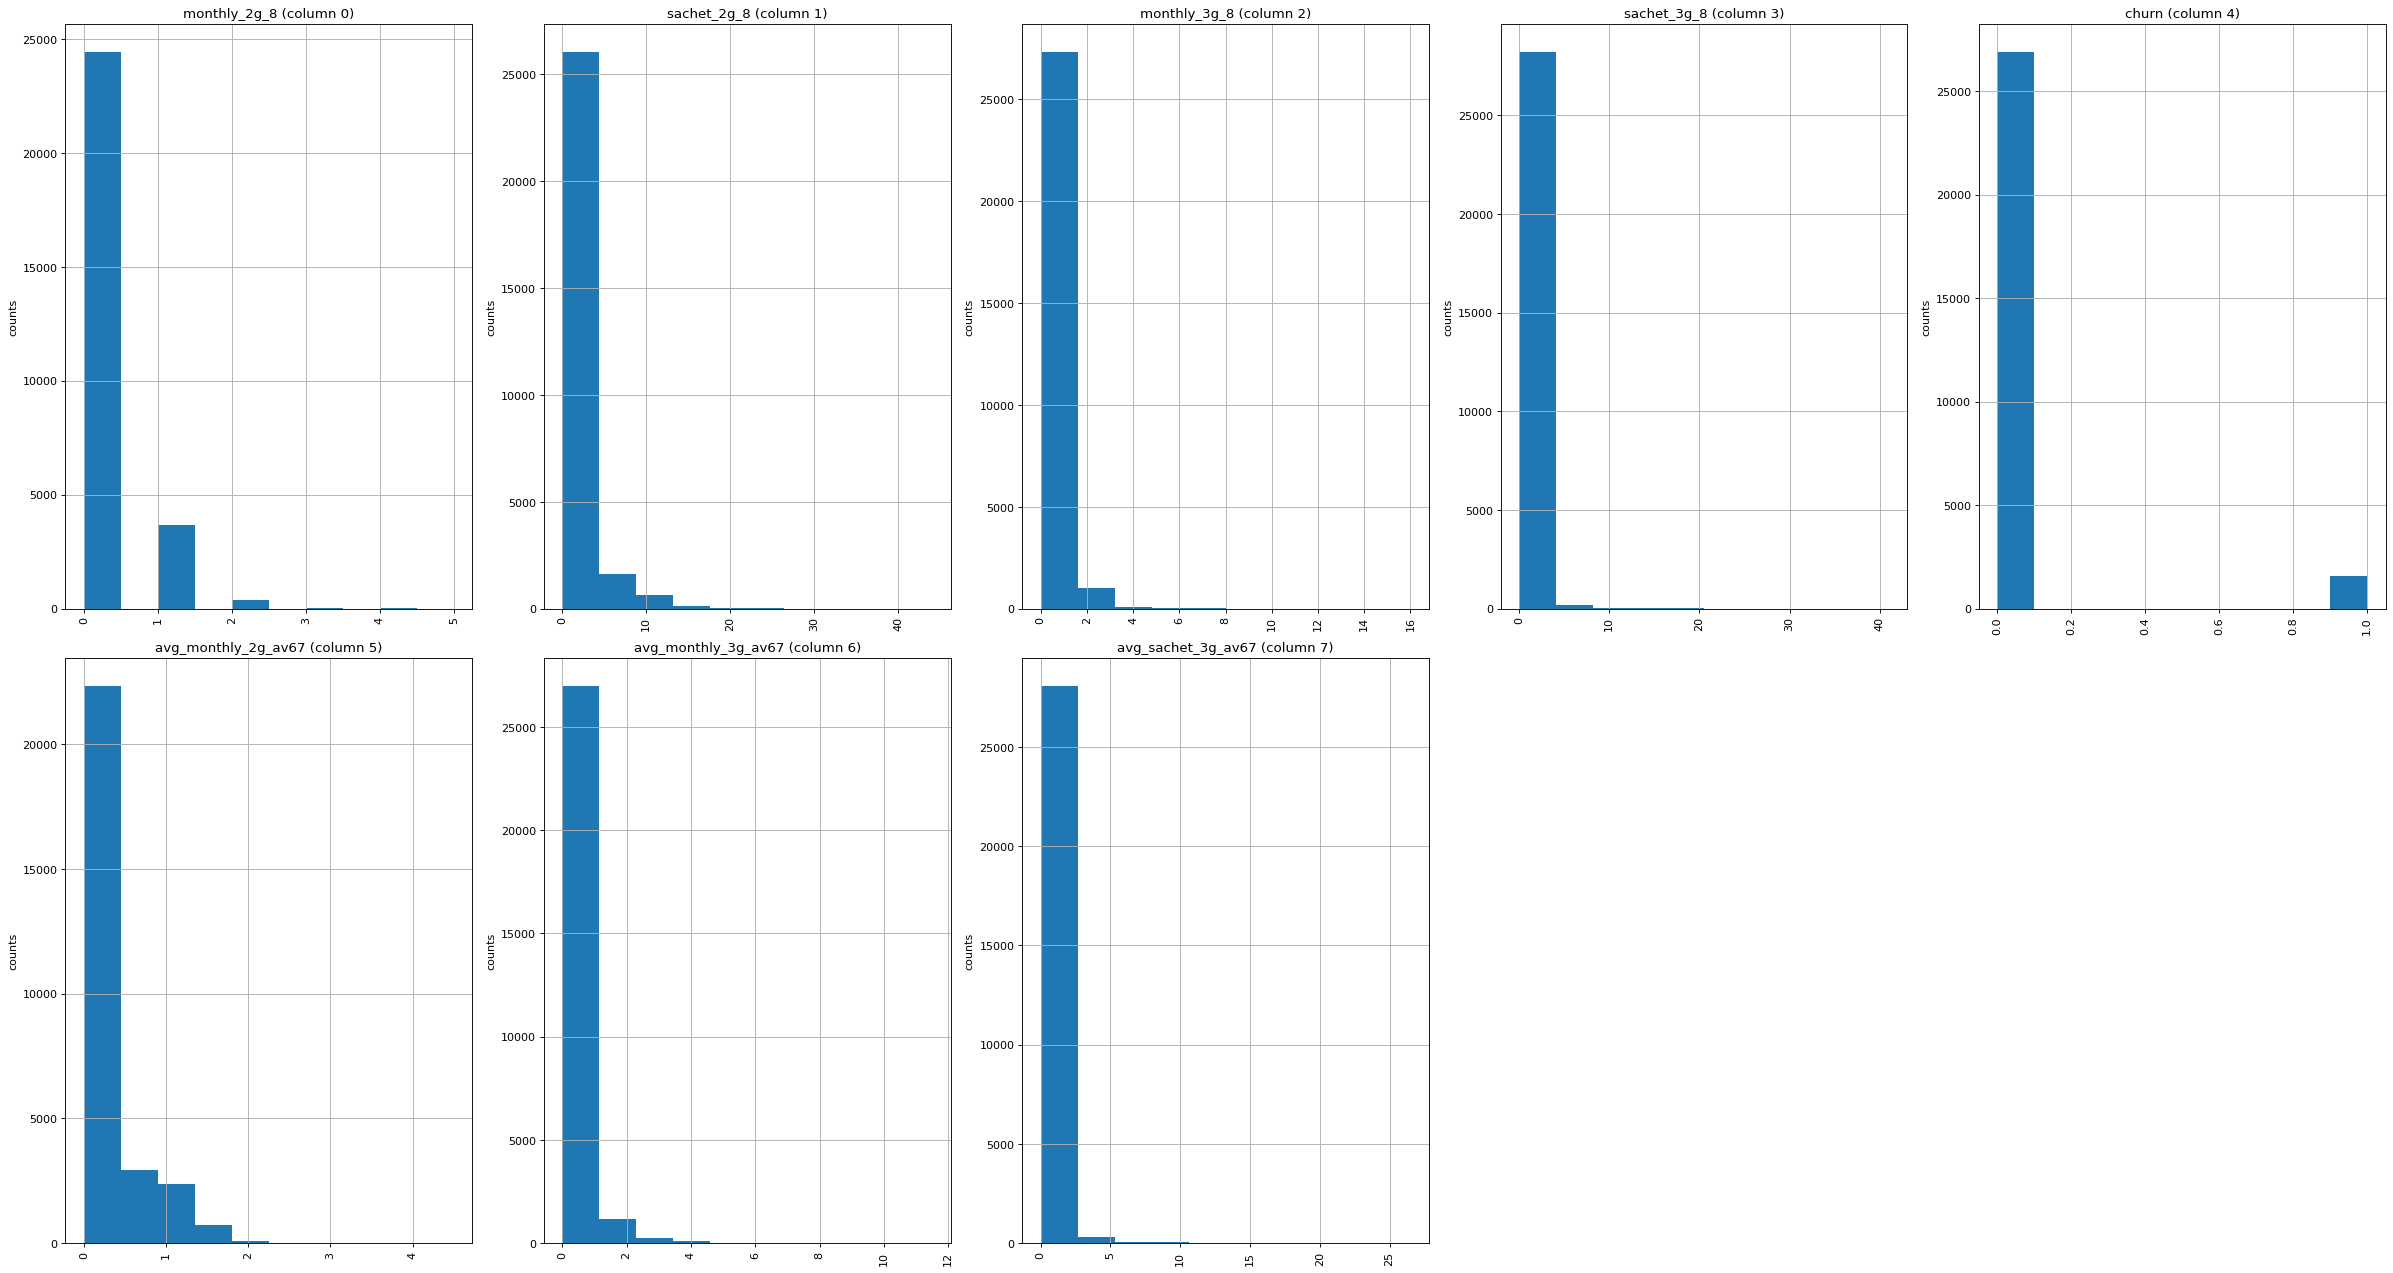

In [ ]:
# lets again draw the plots with the updated dataset
plotPerColumnDistribution(telecom_hv_cust, telecom_hv_cust.shape[1], 5)

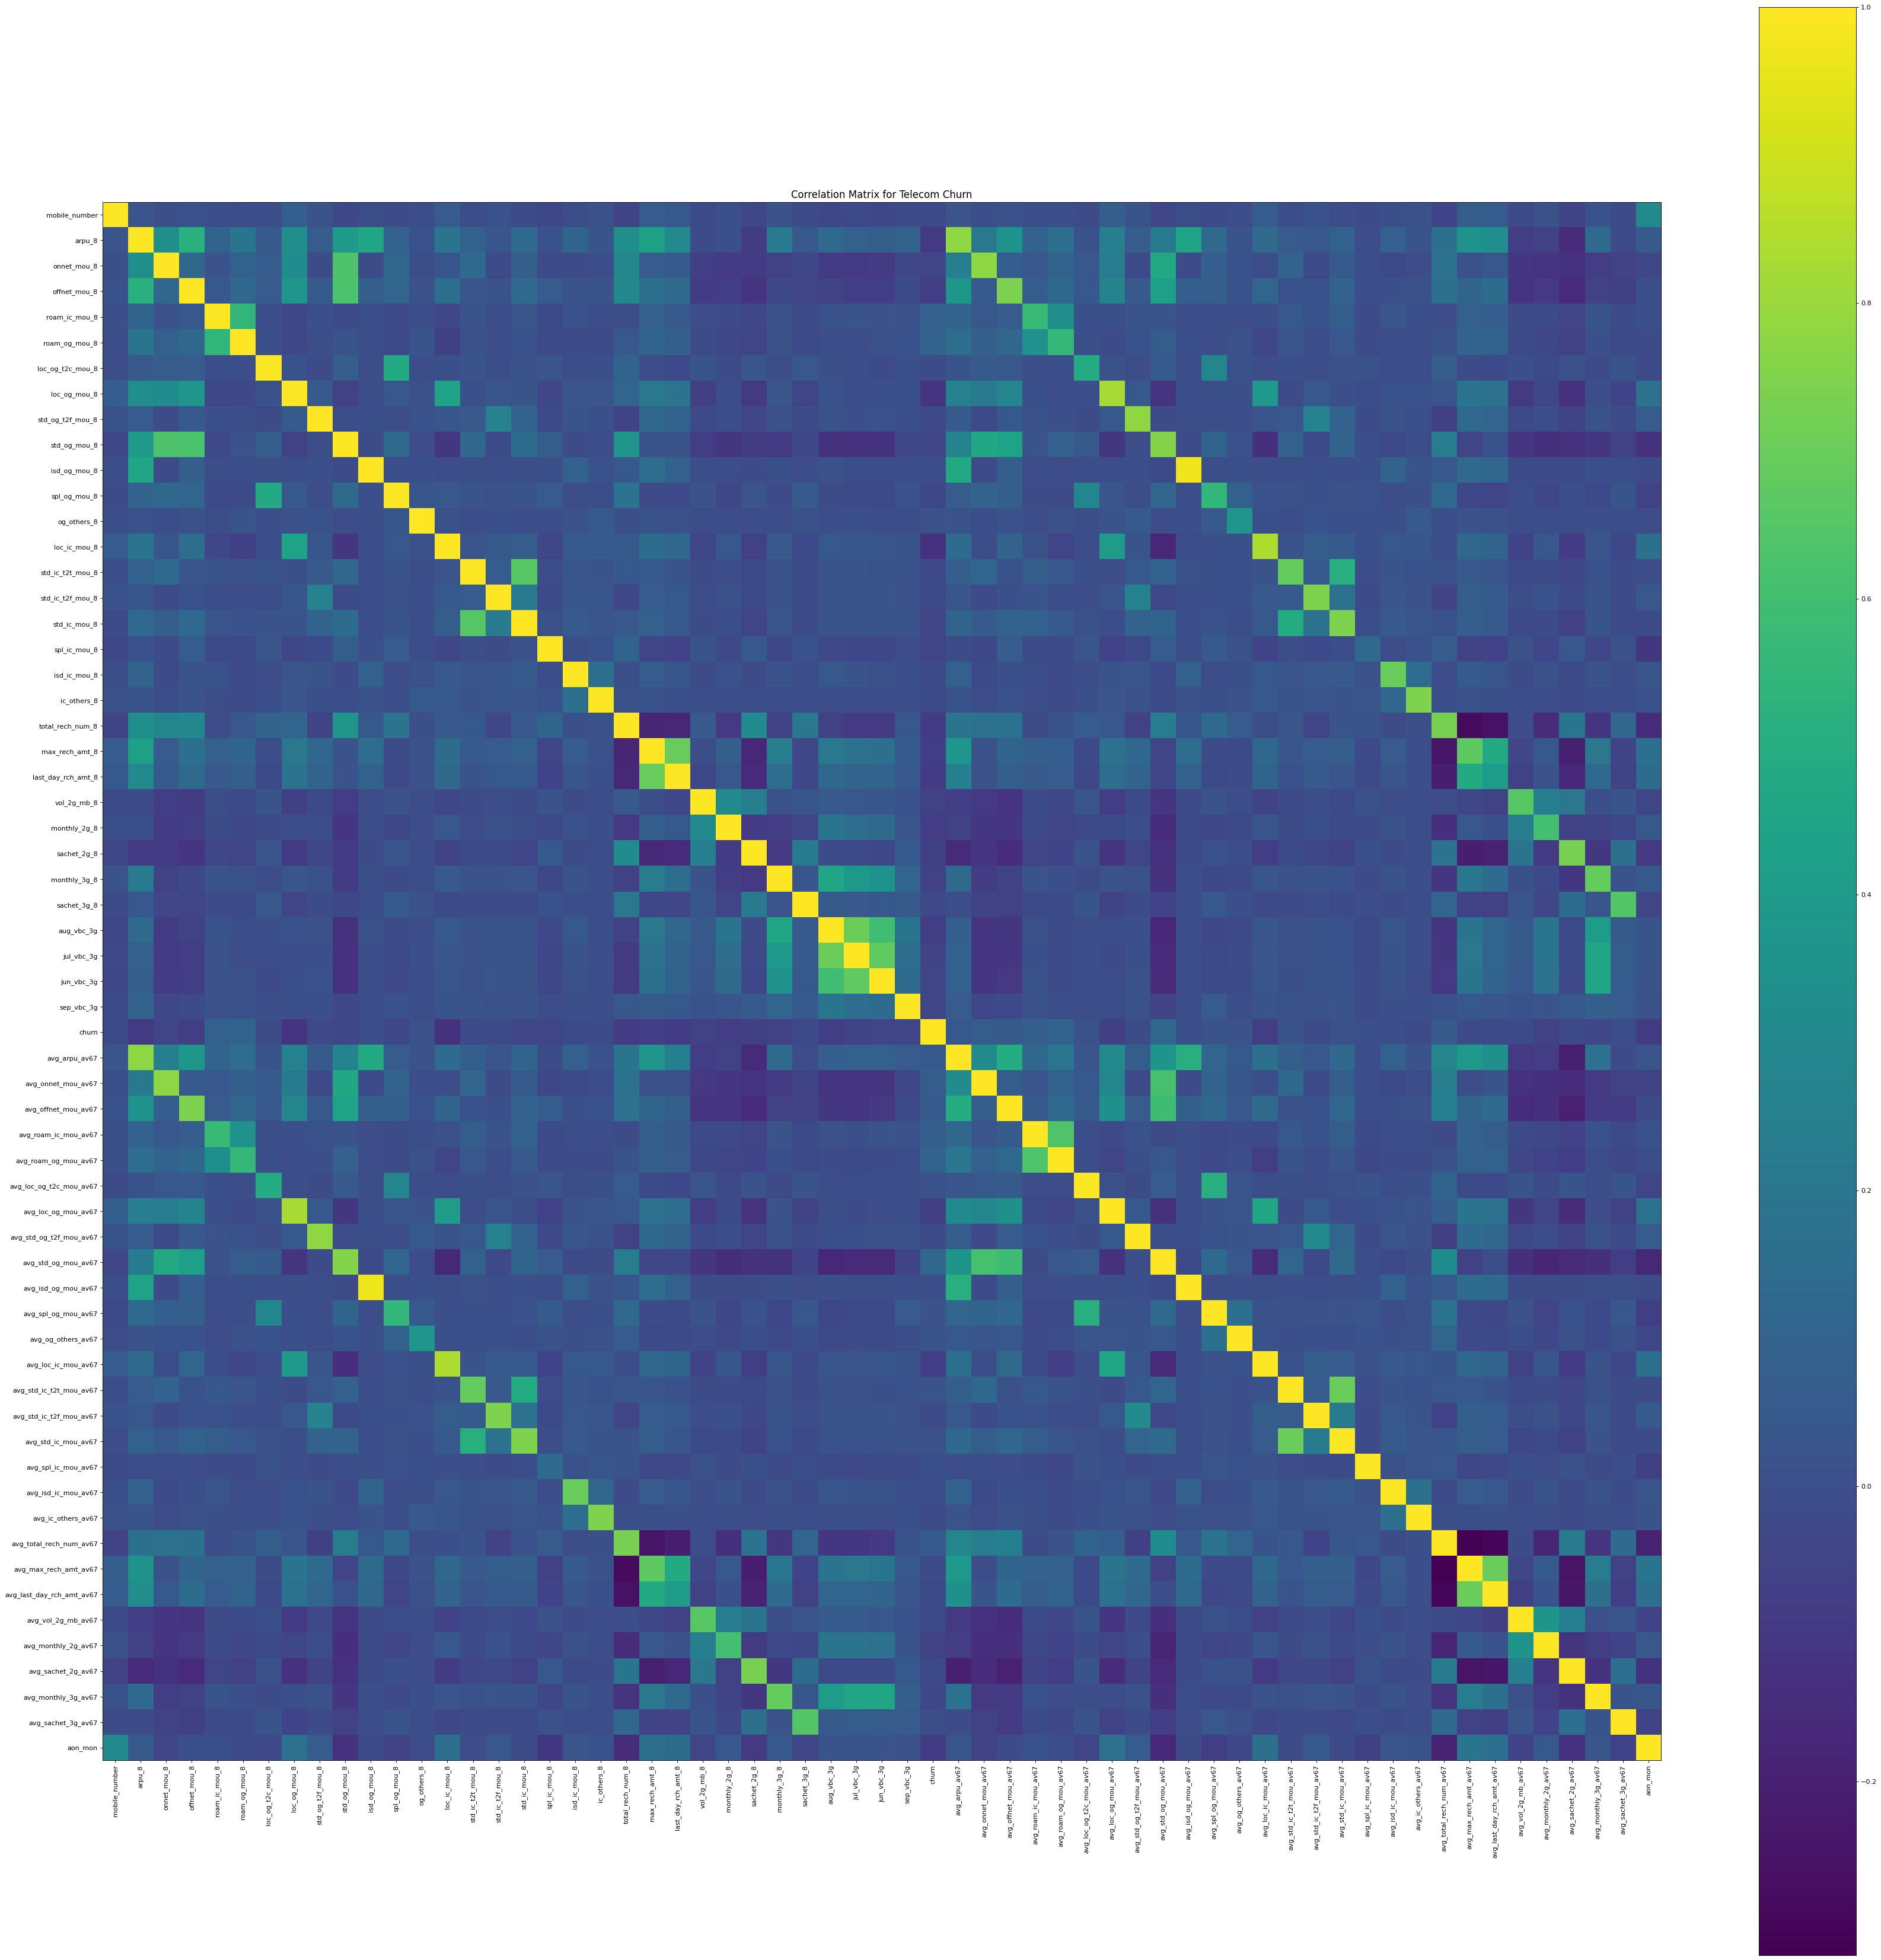

In [ ]:
plotCorrelationMatrix(telecom_hv_cust, 53)

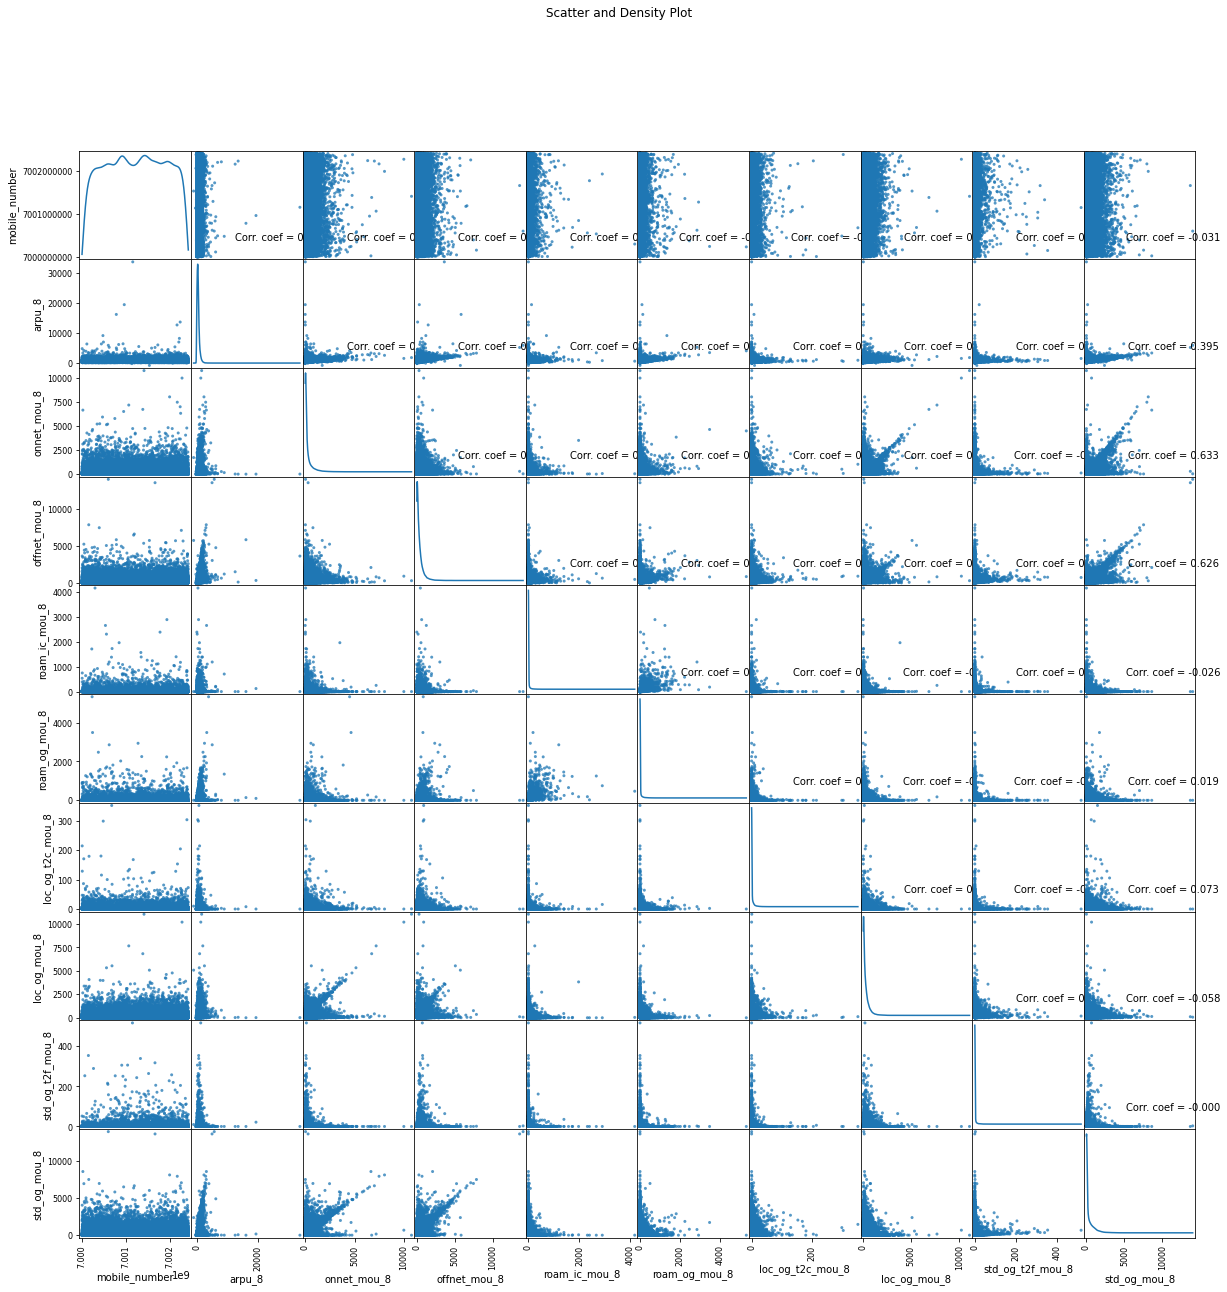

In [ ]:
plotScatterMatrix(telecom_hv_cust, 20, 10)

Text(0.5, 1.0, 'Tenure Graph')

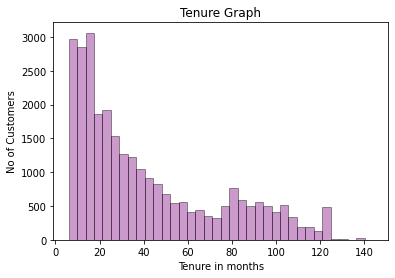

In [ ]:
# Plot distribution of AON (in months)

ax = sns.distplot(telecom_hv_cust['aon_mon'], hist=True, kde=False, 
             bins=int(180/5), color = 'purple', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 10})

ax.set_ylabel('No of Customers')
ax.set_xlabel('Tenure in months')
ax.set_title('Tenure Graph')


In [ ]:
# Bin the AON data
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_hv_cust['tenure_range'] = pd.cut(telecom_hv_cust['aon_mon'], tn_range, labels=tn_label)
telecom_hv_cust['tenure_range'].head()

7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
33        2-5 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

# 7.Bivariate analysis on 'churn'

<AxesSubplot:>

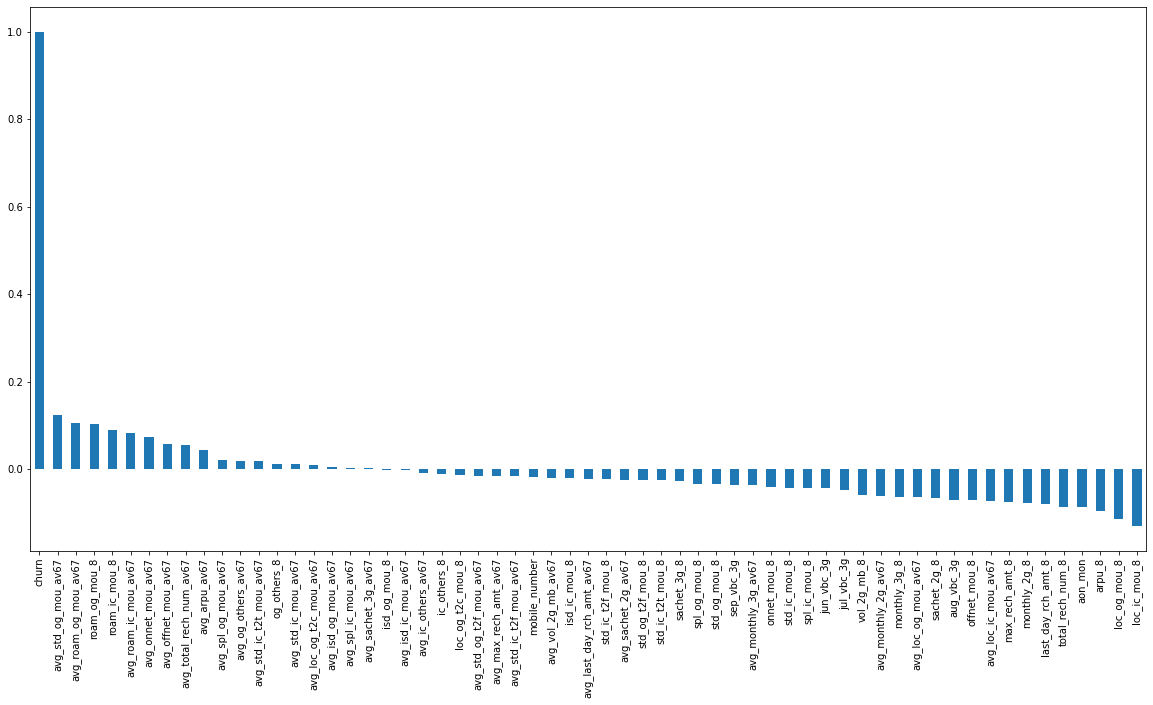

In [ ]:
# Correlation of churn with other columns
plt.figure(figsize=(20,10))
telecom_hv_cust.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

**OBSERVARIONS** 
* Avg Outgoing Calls & calls on romaning for 6 & 7th months are positively correlated with churn. 
* Avg Revenue, No. Of Recharge for 8th month has negative correlation with churn.

<AxesSubplot:xlabel='total_rech_num_8', ylabel='arpu_8'>

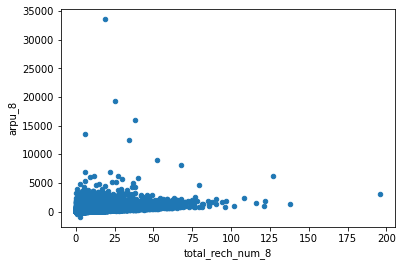

In [ ]:
# lets now draw a scatter plot between total recharge and avg revenue for the 8th month
telecom_hv_cust[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')

<AxesSubplot:xlabel='aon_mon', ylabel='avg_arpu_av67'>

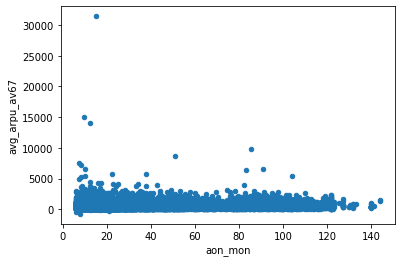

In [ ]:
# plot between tenure and revenue
telecom_hv_cust[['aon_mon', 'avg_arpu_av67']].plot.scatter(x = 'aon_mon',
                                                              y='avg_arpu_av67')

<AxesSubplot:xlabel='churn', ylabel='aon_mon'>

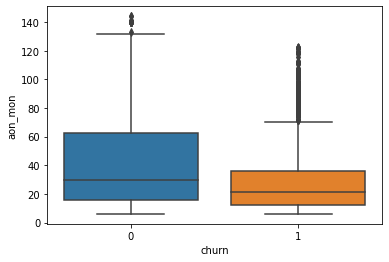

In [ ]:
# AON vs Churn
sns.boxplot(x = telecom_hv_cust.churn, y = telecom_hv_cust.aon_mon)

**OBSERVATIONS**
* Tenured customers do no churn and they keep availing telecom services

Text(0.5, 1.0, 'Churn Vs Base Cost')

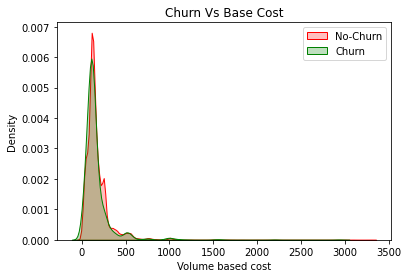

In [ ]:
# churn Vs Base Cost
ax = sns.kdeplot(telecom_hv_cust.avg_max_rech_amt_av67[(telecom_hv_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_hv_cust.avg_max_rech_amt_av67[(telecom_hv_cust["churn"] == 1)],
                ax =ax, color="Green", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Churn Vs Base Cost')

Text(0.5, 1.0, 'Distribution of Max Recharge Amount by churn')

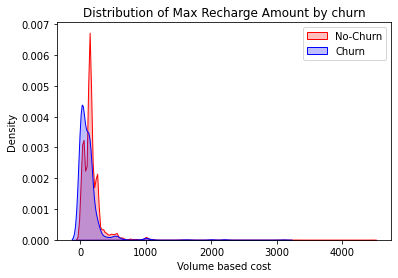

In [ ]:
# churn vs max rechare amount
ax = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Max Recharge Amount by churn')

# 8.Data preparation for Model Building

In [ ]:
# Create new dataset for model building
df = telecom_hv_cust[:].copy()

# lets drop tenure range because it is highly correlated with AON MONTH column
df.drop('tenure_range', axis=1, inplace=True)
df.drop('mobile_number', axis=1, inplace=True)
df.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,...,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,aon_mon
7,3171.480,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,10.01,...,15.465,5.0,1185.0,0.0,0.000,0.0,0.0,0.0,0.0,26.733333
8,137.362,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,0.00,...,0.000,20.0,122.0,25.0,178.000,0.5,0.5,0.0,0.0,10.500000
21,637.760,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,0.00,...,0.000,24.0,50.0,25.0,0.000,0.0,0.0,0.0,0.0,24.000000
23,366.966,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,0.00,...,2.675,4.0,89.5,89.5,0.240,0.0,0.0,1.0,0.0,20.133333
33,409.230,0.00,0.00,0.00,0.00,0.56,0.00,0.00,0.00,0.00,...,0.940,10.5,753.5,126.0,72.405,0.0,0.0,4.5,2.0,44.266667


In [ ]:
# Create X & y dataframes for independent and target variables
X = df.drop(['churn'], axis=1)
y = df['churn']

df.drop('churn', axis=1, inplace=True)


## Scale the data using Standard Scaler

In [ ]:
# apply scaling on the dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

## Train-test split

In [ ]:
# split the dateset into train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (19952, 59)
Dimension of X_test: (8552, 59)


## Fix Data imbalance using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=45, k_neighbors=5)
X_tr,y_tr = sm.fit_resample(X_train, y_train)
len(X_tr)

37666

In [ ]:
print("Dimension of X_tr Shape:", X_tr.shape)
print("Dimension of y_tr Shape:", y_tr.shape)

print("Imbalance in Training dataset:",(y_tr != 0).sum()/(y_tr == 0).sum())

Dimension of X_tr Shape: (37666, 59)
Dimension of y_tr Shape: (37666,)
Imbalance in Training dataset: 1.0


# 9.Model Building

## SVM Model

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

lr = LogisticRegression()

lr.svm = SVC(kernel='linear') 
lr.svm.fit(X_train,y_train)
preds = lr.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)*100

94.19400105244694

**OBSERVATIONS**
* Linear SVM gave us accuracy of 94% on test data

## RFE for feature elimination

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
from sklearn.feature_selection import RFE

rfe = RFE(lr, n_features_to_select=15)   
rfe = rfe.fit(X_tr, y_tr)

In [ ]:
# Top 15 columns
list(df.columns[rfe.support_])

['onnet_mou_8',
 'offnet_mou_8',
 'roam_og_mou_8',
 'loc_og_mou_8',
 'loc_ic_mou_8',
 'std_ic_mou_8',
 'spl_ic_mou_8',
 'last_day_rch_amt_8',
 'monthly_2g_8',
 'sachet_2g_8',
 'monthly_3g_8',
 'sep_vbc_3g',
 'avg_loc_og_mou_av67',
 'avg_std_og_mou_av67',
 'avg_loc_ic_mou_av67']

In [ ]:
X_rfe = pd.DataFrame(data=X_tr).iloc[:, rfe.support_]
y_rfe = y_tr

## Logistic regression model using RFE supported columns

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)
lr.fit(X_rfe, y_rfe)

LogisticRegression(random_state=1)

In [ ]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

y_pred = lr.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_matrix)
print('Accuracy on the test data:',lr.score(X_test_rfe, y_test))

Confusion Matrix:
[[4151 1219]
 [  60  271]]
Accuracy on the test data: 0.7756533941413787


In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87      5370
           1       0.18      0.82      0.30       331

    accuracy                           0.78      5701
   macro avg       0.58      0.80      0.58      5701
weighted avg       0.94      0.78      0.83      5701



**OBSERVATIONS**

* Model Accuracy is approx 78%
* Confusion matix shows high false positive rate, which is not good.

lets try PCA

## PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to correct class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=45, k_neighbors=5)
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(37666, 59)
(37666,)


In [ ]:
# import PCA
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

In [ ]:
# Apply PCA on train data
pca.fit(X_tr)

PCA(random_state=100)

In [ ]:
X_tr_pca = pca.fit_transform(X_tr)
print(X_tr_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

(37666, 59)
(8552, 59)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca = LogisticRegression(C=1e9)
lr_pca.fit(X_tr_pca, y_tr)

# make the predictions
y_pred = lr_pca.predict(X_test_pca)

# convert prediction array into a dataframe
y_pred_df = pd.DataFrame(y_pred)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))
print("Accuracy of the logistic regression model with PCA: ",accuracy_score(y_test,y_pred))

[[6482 1593]
 [  91  386]]
Accuracy of the logistic regression model with PCA:  0.803086997193639


In [ ]:
col = list(df.columns)
df_pca = pd.DataFrame({'PC-1':pca.components_[0],'PC-2':pca.components_[1], 'PC-3':pca.components_[2],'Feature':col})
df_pca.head(10)

,PC-1,PC-2,PC-3,Feature
0,0.201772,0.221575,0.176554,arpu_8
1,0.088944,0.217498,-0.057001,onnet_mou_8
2,0.137021,0.222979,0.037024,offnet_mou_8
3,0.375391,-0.207257,-0.082077,roam_ic_mou_8
4,0.384290,-0.138265,-0.100283,roam_og_mou_8
5,0.018210,0.079578,-0.026507,loc_og_t2c_mou_8
6,0.042035,0.136163,0.175195,loc_og_mou_8
7,0.025874,0.020562,0.079743,std_og_t2f_mou_8
8,0.079307,0.273665,-0.108263,std_og_mou_8
9,0.056014,0.079798,0.105886,isd_og_mou_8


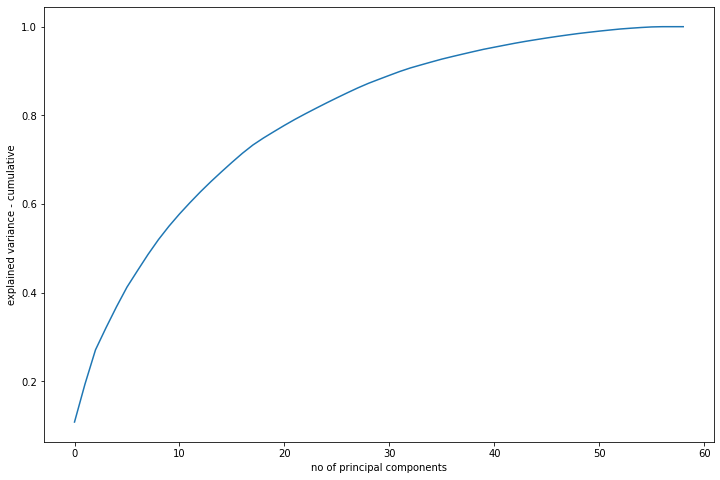

In [ ]:
# scree plot to check the variance explained by different PCAs
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no of principal components')
plt.ylabel('explained variance - cumulative')
plt.show()

In [ ]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.84,  19.41,  27.12,  32.09,  36.83,  41.27,  44.97,  48.61,
        51.98,  55.  ,  57.75,  60.31,  62.76,  65.07,  67.26,  69.39,
        71.45,  73.32,  74.89,  76.33,  77.74,  79.09,  80.36,  81.59,
        82.79,  83.96,  85.1 ,  86.2 ,  87.22,  88.13,  89.03,  89.91,
        90.7 ,  91.38,  92.05,  92.7 ,  93.28,  93.84,  94.39,  94.93,
        95.39,  95.85,  96.3 ,  96.72,  97.1 ,  97.47,  97.82,  98.15,
        98.47,  98.75,  99.02,  99.27,  99.5 ,  99.68,  99.84,  99.97,
       100.02, 100.02, 100.02])

**OBSERVATIONS**
* 33 columns explains 90% of the variance, lets apply PCA with 33 components

In [ ]:
# PCA with 33 components
pca_33 = PCA(n_components=33)

df_tr_pca_33 = pca_33.fit_transform(X_tr)
print(df_tr_pca_33.shape)

df_test_pca_33 = pca_33.transform(X_test)
print(df_test_pca_33.shape)

(37666, 33)
(8552, 33)


In [ ]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca1 = LogisticRegression(C=1e9)
lr_pca1.fit(df_tr_pca_33, y_tr)

# Predicted probabilities
y_pred33 = lr_pca1.predict(df_test_pca_33)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred33)

print("Accuracy with 33 PCAs: ",accuracy_score(y_test,y_pred33))

Accuracy with 33 PCAs:  0.8007483629560337


In [ ]:
print(confusion_matrix(y_test,y_pred33))

[[6475 1600]
 [ 104  373]]


**OBSERVATIONS**

* Model has 80% Accuracy
* 33 features can explain 90% variance in the dataset
* most imp features are: 
  1. arpu_8
  2. onnet_mou_8 
  3. offnet_mou_8
  4. roam_ic_mou_8
  5. roam_og_mou_8

## Decision Tree

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to tackle class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=45, k_neighbors=5)
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(37666, 59)
(37666,)


In [ ]:
# feature selection using lasso
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
svc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
svc_model = SelectFromModel(svc, prefit=True)
X_lasso = svc_model.transform(X_tr)
position = svc_model.get_support(indices=True)

print(X_lasso.shape)
print(position)

(37666, 34)
[ 0  2  4  6  7  8 10 12 15 16 19 21 22 23 24 25 26 27 30 31 32 33 34 35
 39 43 44 46 50 51 53 54 55 58]


In [ ]:
# feature vector for decision tree
lasso_features = list(df.columns[position])
print("Lasso Features: ", lasso_features)

Lasso Features:  ['arpu_8', 'offnet_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aug_vbc_3g', 'sep_vbc_3g', 'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67', 'avg_std_og_mou_av67', 'avg_loc_ic_mou_av67', 'avg_std_ic_t2t_mou_av67', 'avg_std_ic_mou_av67', 'avg_total_rech_num_av67', 'avg_max_rech_amt_av67', 'avg_vol_2g_mb_av67', 'avg_monthly_2g_av67', 'avg_sachet_2g_av67', 'aon_mon']


In [ ]:
# import decision tree libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# lets create a decision tree with the default hyper parameters except max depth to make the tree readable
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5)

In [ ]:
# lets see the classification reort of the model built
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model predictions
X_test = pd.DataFrame(data=X_test).iloc[:, position]
y_pred1 = dt1.predict(X_test)

# classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      8075
           1       0.24      0.73      0.36       477

    accuracy                           0.86      8552
   macro avg       0.61      0.80      0.64      8552
weighted avg       0.94      0.86      0.89      8552



In [ ]:
# confusion matrix
print(confusion_matrix(y_test,y_pred1))
# accuracy of the decision tree
print('Decision Tree - Accuracy :',accuracy_score(y_test,y_pred1)*100)

[[6988 1087]
 [ 130  347]]
Decision Tree - Accuracy : 85.76941066417211


### Lets fine tune hyperparameters

#### Optimal Depth

In [ ]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)
                               
# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'max_depth': range(1, 40)}, return_train_score=True,
             scoring='accuracy')

In [ ]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.106746,0.009246,0.002160,0.000378,1,{'max_depth': 1},0.772233,0.795699,0.801142,0.798221,...,0.793846,0.011031,39,0.799250,0.793383,0.792022,0.792752,0.791823,0.793846,0.002758
1,0.177789,0.006151,0.002161,0.000123,2,{'max_depth': 2},0.809928,0.823045,0.826762,0.825700,...,0.822201,0.006256,38,0.827194,0.822686,0.824113,0.822089,0.823084,0.823833,0.001805
2,0.250684,0.008276,0.001955,0.000224,3,{'max_depth': 3},0.824396,0.842294,0.843090,0.849462,...,0.841104,0.008731,37,0.840402,0.844523,0.838615,0.842764,0.843262,0.841913,0.002122
3,0.322176,0.007479,0.002077,0.000224,4,{'max_depth': 4},0.831431,0.854109,0.857560,0.859684,...,0.852573,0.010781,36,0.856299,0.856038,0.851326,0.855209,0.853848,0.854544,0.001822
4,0.408146,0.004838,0.002292,0.000033,5,{'max_depth': 5},0.844837,0.862472,0.862339,0.867384,...,0.861255,0.008644,35,0.869972,0.863771,0.864468,0.868981,0.865297,0.866498,0.002499


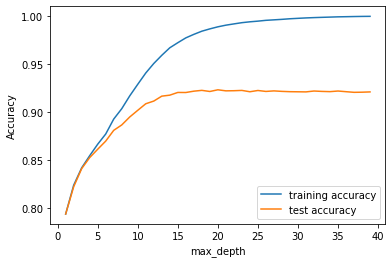

In [ ]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(score["param_max_depth"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_max_depth"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**OBSERVATIONS**
* max_depth of 10 seems to be the optimal one

#### Optimal Minimum sample leaf

In [ ]:
# Find optimal value of minimum sample leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [ ]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.435572,0.095074,0.003002,0.000440,5,{'min_samples_leaf': 5},0.882665,0.916102,0.922873,0.918359,...,0.913371,0.015794,1,0.971260,0.964889,0.966681,0.968739,0.967710,0.967856,0.002125
1,1.050280,0.025235,0.002639,0.000215,25,{'min_samples_leaf': 25},0.869790,0.900571,0.908005,0.906014,...,0.899539,0.015423,2,0.927552,0.920054,0.919656,0.924435,0.922908,0.922921,0.002919
2,0.961941,0.053300,0.003236,0.000906,45,{'min_samples_leaf': 45},0.858375,0.886234,0.896854,0.896854,...,0.887300,0.015091,3,0.908038,0.904324,0.904656,0.907245,0.904225,0.905697,0.001613
3,0.955661,0.077406,0.002812,0.000332,65,{'min_samples_leaf': 65},0.854659,0.883446,0.893933,0.887429,...,0.883185,0.014990,4,0.899476,0.893140,0.893240,0.897090,0.896127,0.895815,0.002404
4,0.843785,0.015721,0.002679,0.000155,85,{'min_samples_leaf': 85},0.850279,0.875348,0.892208,0.885039,...,0.878963,0.015599,5,0.893502,0.884910,0.889357,0.888793,0.888395,0.888991,0.002740


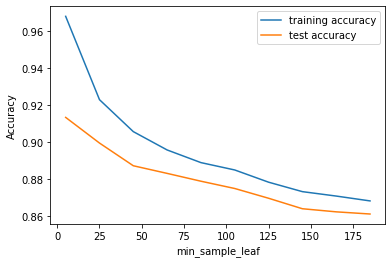

In [ ]:
# plotting accuracies with min_sample_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_sample_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**OBSERVATIONS** 
* 25 min_sample_leaf 25 seems to be the optimal one

#### Optimal Min sample split

In [ ]:
# Optimal min sample split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_split': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.332558,0.056004,0.002809,0.000310,5,{'min_samples_split': 5},0.893417,0.924200,0.927386,0.931369,...,0.921389,0.014214,1,0.995885,0.994093,0.994259,0.994159,0.993794,0.994438,0.000740
1,1.430883,0.106766,0.003447,0.000913,25,{'min_samples_split': 25},0.881205,0.914642,0.921412,0.920616,...,0.912176,0.015742,2,0.969169,0.964789,0.964922,0.967345,0.964225,0.966090,0.001875
2,1.410265,0.159967,0.003272,0.000700,45,{'min_samples_split': 45},0.874967,0.905748,0.912784,0.913182,...,0.905486,0.015981,3,0.954600,0.945873,0.949358,0.949623,0.947101,0.949311,0.002992
3,1.419544,0.117854,0.002726,0.000453,65,{'min_samples_split': 65},0.870852,0.899376,0.904288,0.906279,...,0.899273,0.015150,4,0.940927,0.934358,0.937444,0.939136,0.935917,0.937556,0.002315
4,1.301567,0.068416,0.002779,0.000337,85,{'min_samples_split': 85},0.866207,0.897783,0.903757,0.901766,...,0.895875,0.015339,5,0.933393,0.928085,0.930143,0.931105,0.928085,0.930163,0.001998


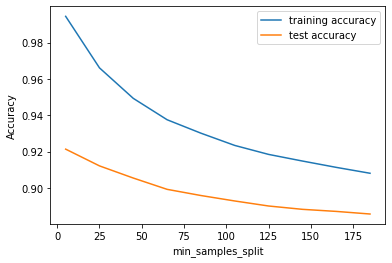

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**OBSERVATIONS**
* min_samples_leaf of 50 seems to be optimal

#### Parameter grid

In [ ]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_lasso, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(25, 175, 50),
                         'min_samples_split': range(50, 150, 50)},
             verbose=1)

In [ ]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values('rank_test_score').head(15)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,0.787745,0.079208,0.002706,0.000442,gini,10,25,50,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.868728,0.894066,0.900704,0.897783,0.901766,0.892609,0.012236,1
19,0.722332,0.037434,0.002498,0.000576,gini,10,25,100,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.862225,0.888092,0.897518,0.894863,0.896190,0.887777,0.013182,2
6,0.908920,0.131565,0.002606,0.000577,entropy,10,25,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.858110,0.885836,0.900571,0.892208,0.892871,0.885919,0.014669,3
7,0.789712,0.005287,0.002539,0.000207,entropy,10,25,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.848951,0.883977,0.897916,0.890880,0.886632,0.881671,0.017025,4
20,0.666863,0.014590,0.002915,0.001105,gini,10,75,50,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.850411,0.878800,0.889420,0.884774,0.891013,0.878884,0.014856,5
21,0.662016,0.013425,0.002431,0.000241,gini,10,75,100,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.850411,0.878269,0.889420,0.884774,0.891013,0.878777,0.014858,6
8,0.759611,0.013380,0.002461,0.000172,entropy,10,75,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.842182,0.873357,0.889685,0.880658,0.877207,0.872618,0.016149,7
9,0.885932,0.102796,0.002665,0.000229,entropy,10,75,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.842182,0.873357,0.889420,0.880658,0.877207,0.872565,0.016093,8
23,0.643593,0.014556,0.002443,0.000098,gini,10,125,100,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.844173,0.872959,0.878003,0.873490,0.877340,0.869193,0.012670,9
22,0.725437,0.046082,0.002728,0.000240,gini,10,125,50,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.844173,0.872959,0.878003,0.873490,0.877340,0.869193,0.012670,9


In [ ]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=50)


In [ ]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=25,
                                  min_samples_split=50)
clf_gini.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=25, min_samples_split=50,
                       random_state=100)

In [ ]:
# accuracy score
print ('Accuracy Score for Decision Tree Final Model :',clf_gini.score(X_test,y_test))

Accuracy Score for Decision Tree Final Model : 0.8585126286248831


**Conclusion from the Decision Tree model**
* 85% accuracy on the test dataset
* lots of false positives in the confusion matrix

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier()
model_rf.fit(X_lasso, y_tr)

# Predictions
prediction_test = model_rf.predict(X_test)
print ('Randon Forest Accuracy(Default Hyperparameter)',metrics.accuracy_score(y_test, prediction_test))

Randon Forest Accuracy(Default Hyperparameter) 0.9389616463985033


In [ ]:
print(classification_report(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8075
           1       0.46      0.56      0.51       477

    accuracy                           0.94      8552
   macro avg       0.72      0.76      0.74      8552
weighted avg       0.95      0.94      0.94      8552



In [ ]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

[[7763  312]
 [ 210  267]]


### Optimal max_depth

In [ ]:

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 20, 5)}, return_train_score=True,
             scoring='accuracy')

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.230762,0.149182,0.047319,0.003810,2,{'max_depth': 2},0.819750,0.829815,0.856365,0.830214,...,0.838290,0.014812,4,0.847073,0.833405,0.844323,0.827067,0.846647,0.839703,0.008040
1,5.850848,0.269760,0.065151,0.000829,7,{'max_depth': 7},0.873109,0.890615,0.895925,0.899111,...,0.891680,0.009825,3,0.907009,0.899645,0.898948,0.896459,0.897687,0.899950,0.003694
2,8.376995,0.210894,0.092690,0.005341,12,{'max_depth': 12},0.925139,0.942520,0.947033,0.949821,...,0.942681,0.009124,2,0.973052,0.969303,0.968108,0.968838,0.968208,0.969502,0.001828
3,10.097798,0.356997,0.107968,0.011518,17,{'max_depth': 17},0.942527,0.959910,0.964556,0.966945,...,0.960017,0.009079,1,0.989380,0.989380,0.988916,0.989613,0.988750,0.989208,0.000322


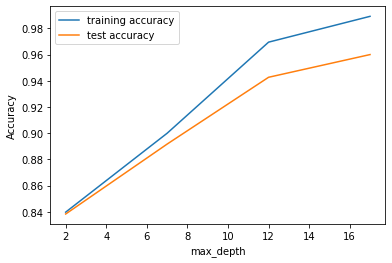

In [ ]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Optimal n_estimators

In [ ]:
from sklearn.model_selection import KFold

n_folds = 5

## parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}
#
## instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=4)
#
#
## fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=4),
             param_grid={'n_estimators': range(100, 1500, 400)},
             return_train_score=True, scoring='accuracy')

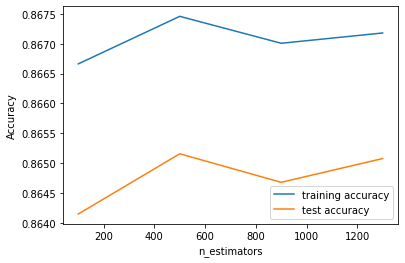

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Optimal min_samples_leaf

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 10)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': range(50, 400, 10)},
             return_train_score=True, scoring='accuracy')

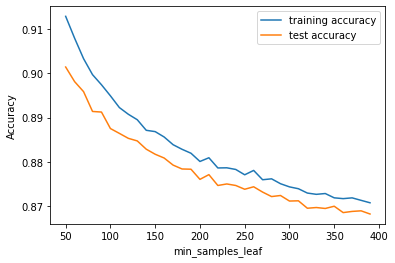

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Optimal min_samples_split

In [ ]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 500, 25)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': range(100, 500, 25)},
             return_train_score=True, scoring='accuracy')

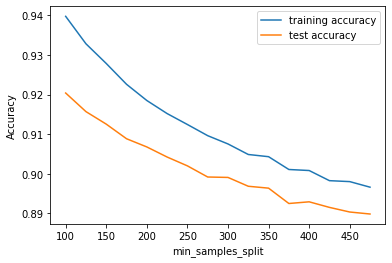

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"],
         scores["mean_train_score"],
         label="training accuracy")
plt.plot(scores["param_min_samples_split"],
         scores["mean_test_score"],
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Parameter grid

In [ ]:
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 300, 100),
    'min_samples_split': range(200, 500, 100),
    'n_estimators': [500,700], 
    'max_features': [10,20,25]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [ ]:
# fit the grid search
grid_search.fit(X_lasso, y_tr)

# optimal accuracy score and hyperparameters
print('Accuracy is',grid_search.best_score_,'using',grid_search.best_params_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 15,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

### Evaluation Metrics

In [ ]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,prediction_test))
print(confusion_matrix(y_test,prediction_test))

In [ ]:
# accuracy score
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(y_test, prediction_test))

In [ ]:
# list of important features
X = df
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

### Conclusions from Random Forest

The most important 

* Local Incoming for Month 8, Average Revenue Per Customer for Month 8 and Max Recharge Amount for Month 8 are the most important predictor variables to predict churn.

# 10.Overall Conclusions

1. Std Outgoing Calls and Revenue Per Customer are strong indicators of Churn.
2. Local Incoming and Outgoing Calls for 8th Month and avg revenue in 8th Month are the most important columns to predict churn.
3. cutomers with tenure less than 4 yrs are more likely to churn.
4. Max Recharge Amount is a strong feature to predict churn.
6. Random Forest produced the best prediction results followed by SVM.
